In [1]:
import os
import sys
sys.path.append('..')
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from FedAvg_utils.data_utils import DatasetFLBEiTPretrain, create_dataset_and_evalmetrix, DatasetFLBEiT

### COVIDx preprocessing

In [ ]:
train_df = pd.read_csv(data_path+'train_a.txt', sep=" ", header=None)
train_df.columns=['patient_id', 'filename', 'class', 'data_source']
train_df=train_df.drop(['patient_id', 'data_source'], axis=1)

train_df.loc[train_df['class']=='positive', 'class'] = 'COVID-19' 
train_df.loc[train_df['class']=='COVID-19', 'class'] = 2
train_df.loc[train_df['class']=='normal', 'class'] = 0 
train_df.loc[train_df['class']=='pneumonia', 'class'] = 1 

In [ ]:
test_df = pd.read_csv(data_path+'test_a.txt', sep=" ", header=None)
test_df.columns=['patient_id', 'filename', 'class', 'data_source']
test_df=test_df.drop(['patient_id', 'data_source'], axis=1)
test_df.loc[train_df['class']=='positive', 'class'] = 'COVID-19' 

In [ ]:
train_df['class'].value_counts()

In [ ]:
test_df['class'].value_counts()

### Retina move test and val to separate file

In [ ]:
train_df = pd.read_csv('/raid/yan/Retina/central/train.csv', sep=" ", header=None)
val_df = pd.read_csv('/raid/yan/Retina/val.csv', sep=" ", header=None)

In [ ]:
train_list = train_df.loc[:,0].to_list() + val_df.loc[:,0].to_list()

In [ ]:
import shutil

for file in os.listdir(path):
    if file in val_df.loc[:,0].to_list():
        shutil.move(path+'/'+file, '/raid/yan/Retina/val/'+file)

In [ ]:
# import csv
# with open('/raid/yan/Retina/train.csv', 'w') as f:
#     writer = csv.writer(f, delimiter='\n')
#     writer.writerow(train_list)

In [ ]:
train_label = [label for fname, label in labels.items() if fname in img_paths]

In [ ]:
# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html

In [2]:
# COVID mean and std
class Args:
    # data_set = 'COVIDx'
    data_set = 'Retina'
    input_size = 224
    window_size = (224 // 16, 224 //16)
    second_input_size = 112
    train_interpolation='bicubic'
    second_interpolation='lanczos'
    num_mask_patches=75
    max_mask_patches_per_block=None
    min_mask_patches_per_block=16
    split_type='central' 
    # single_client='train.csv' 
    single_client='train.csv' 
    discrete_vae_type = "dall-e"
    data_path = '/data/yan/SSL-FL/Retina/'
    # data_path = '/data/yan/SSL-FL/COVIDx/'

args=Args()

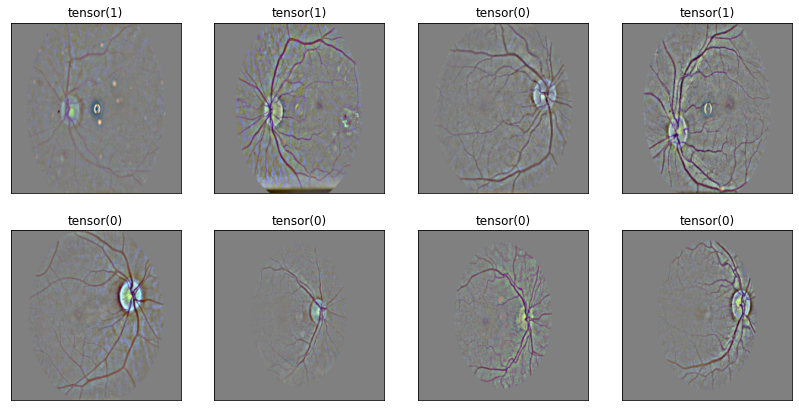

In [6]:
nimages = 0
mean = 0.0
var = 0.0

dataset_train = DatasetFLBEiTPretrain(args, no_transform=True)
# dataset_train = DatasetFLBEiT(args, phase='train')
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, 
    batch_size=32,
    num_workers=1,
    pin_memory=True,
    shuffle=False, 
    # drop_last=True,
)

def denoramlize(img):
    img = img.permute(1,2,0)
    
    mean = torch.FloatTensor((0.5518, 0.5518, 0.5518))
    std = torch.FloatTensor((0.2051, 0.2051, 0.2051))
    img = img*std + mean
    img = np.clip(img,0,1)
    return img

for batch_idx, batch_target in enumerate(data_loader_train):
    # batch_target = np.array(batch_target)
    # print(batch_target.shape)
    # inputs = batch_target[0][0]
    # print(inputs)
    inputs = batch_target[0]
    # print(inputs)
    # print(np.array(batch_target).shape)
    fig = plt.figure(figsize = (14, 7))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].permute(1,2,0))
        plt.title(batch_target[1][i])
    break

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    
    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [ ]:
mean, std = get_mean_and_std(data_loader_train)

In [ ]:
#covidx mean 0.5518, 0.5518, 0.5518
#covidx std 0.2051, 0.2051, 0.2051

In [ ]:
#retina mean 0.5007, 0.5010, 0.5019
# retina std 0.0342, 0.0535, 0.0484

In [ ]:
# pixel count
count = len(dataset_train) * args.input_size * args.input_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

In [ ]:
from PIL import Image
img = np.array(Image.open('/raid/yan/COVIDx/train/sub-S03191_ses-E06595_run-1_bp-chest_vp-pa_dx-corrected.png'))
# img = Image.open('/raid/yan/COVIDx/train/wong-0000.jpg')

In [ ]:
np.stack((img,)*3, axis=-1).shape

In [ ]:
# if img.ndim < 3:
#     img = np.stack((img,)*3, axis=-1)
if img.shape[2] >= 3:
    img = img[:,:,:3]
    plot = True
    plt.figure()
    plt.imshow(img)
    plt.title('new')
    plt.show()

In [ ]:
# sample = np.transpose(img,(2,0,1))
sample = Image.fromarray(np.uint8(img))